# Dynamics on Networks

##### Authors: Mauricio Barahona and Robert Peach

##### Motivation

When studying a dynamical process, we are concerned with its behavior as a function of time, space, and its parameters. We may want to examine how many people are infected by a biological contagion and whether it persists from one season to another, whether and to what extent interacting oscillators synchronize, whether a meme on the internet becomes viral or not, and more. Common to these systems is that the dynamics are occurring on a discrete set of entities, i.e., on the nodes of a network, that are connected to each other in some non-trivial way.

Many real-world systems may be described as a network of dynamically interacting entities. Social networks facilitate the propagation of rumours and the spread of pathogens; the powergrid that connect our cities and homes enable the flow of electrical energy; our economies are supported by the micro-economic trading between individuals and businesses. Common to these systems is that the dynamics are occurring on a discrete set of entities, i.e., on the nodes of a network, that are connected to each other in some non-trivial way. Understanding the dynamics of these systems is essential if we are to redesign them, or guide/control them towards different behaviours. 

![title](images/london_underground.gif)
<p style="text-align:center">The london underground is a physical transport system that can be modelled as a network.</p> 

Naturally we can ask **how non-trivial connectivity, and thus the topology of our network structures, affects dynamical processes?**


*Note: Not only can network structure affect dynamical processes on a network, but also that dynamical processes can affect the dynamics of the network itself. For example, when a child gets the flu, he/she might not go to school for a couple of days, and this temporary change in human activity affects which social contacts take place, which can in turn affect the dynamics of disease propagation. We won't touch on the dynamics of networks, i.e., networks changing over time, but we emphasise that this is also an interesting area that is little explored in network science.*



##### What do we touch on in this notebook?
We will look at a couple of examples of fundamental dynamical phenomena over networked systems.

1. We will apply the Kuramoto model on networks.
2. Look at epidemiological infection models on networks.
3. Understand how network topology governs dynamical processes.


In [60]:
# lets make some basic imports
from functools import partial

import numpy as np
from scipy.integrate import solve_ivp
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import random

## Synchronisation

Synchronization is a ubiquitous phenomenon, universally found both in natural and human-engineered systems. From firing neurons to the twinkling of fireflies, from metronomes to power grids, from applauding audiences to the circadian rhythms of plants and animals. All of these systems display similar synchronization behaviors. Patterns and order magically emerge from the disordered interplay of many interacting parts, with a complexity
which seems to give no hope for simple models. As it often happens in complex systems, however, their obvious differences fade away when the phenomenon is examined at the right scale and with the right level of abstraction. The way synchronization occurs seems to be independent of whether the agents are singing crickets, heart cells or metronomes.


![title](images/sync.png)


#### Systems of oscillators



We can define the angle that the oscillator makes with the x-axis at some time $t$ as $\theta(t) = \omega t + \theta_0$, where $ω$ is the natural frequency of the oscillator. If we have $n$ different *isolated* oscillators, each with its own natural frequency $\omega_i ∈ R$, we can describe the evolution of the system with the ordinary system of differential equations.

\begin{align}
    \dot{\theta} = \omega
\end{align}


We stress the word “isolated” because, up to this point, no interaction is considered. The
oscillators are each evolving as by their nature, with no external disruptions!


#### Interacting oscillators: Kuramoto model 

We now come to the central point of explaining how it is possible for a system of oscillators to synchronize. Why do metronomes on a moving platform, each set with its own tempo (natural frequency), synchronize after a few beats? The reason is to be found in their interactions. In each of the synchronizing systems mentioned above, one finds that the oscillators are always coupled, in the sense that they exchange information about their phase. This
could mean different things depending on the specific system: the metronomes are coupled through the slight movements and vibrations of the moving platform, the fireflies can see each other’s light, and the applauding crowd can feel the movement of their seats induced by the applause itself. No matter how weak, interactions disrupt the natural behavior of oscillators, allowing for the emergence of a variety of interesting collective phenomena, of which synchronization is just one.

The Kuramoto model consists of a population of oscillators whose phases are all-to-all coupled. Lets now modify the equation above to include this all-to-all interacting oscillators:


\begin{align}
    \dot \theta_i = \omega_i - \sigma \sum_j \sin(\theta_i - \theta_j)\, .
    \label{eq:kuramoto}
\end{align}

The newly added term on the right hand side tells us that the evolution of the phase of oscillator $i$ is disrupted by the interaction between oscillator $i$ and every other oscillator $j$, modulated by the coupling or interaction strength $\sigma > 0$. First notice that, by the properties of the sine function, the interaction between oscillators $i$ and $j$ will be 0 when $\theta_i − \theta_j = k\pi$ i.e. when $\theta_i$ and $\theta_j$ represent the same angle (in-phase synchronization).

**But is it realistic that all oscillators in, e.g., the brain, are interacting with each other?**

When the network has an intricate topology (described by the adjacency matrix), the Kuramoto model (and its extensions) can lead to rich behavior that is not captured by the synchronized versus desynchronized dichotomy alone. 

![title](images/network_topology.png)


The Kuramoto model is typically formulated for a node phase dynamical variable $\theta \in \mathbb R^{n_0}$, with natural frequencies $\omega = (\omega_1, \ldots, \omega_{n_0}) \in \mathbb R^{n_0}$ that are sitting on the nodes of a graph $G = (V, E)$ ($|V|=n_0$, $|E|=n_1$) and interact through the graph adjacency matrix $A_{ij}\in \mathbb R^{n_0\times n_0}$


\begin{align}
    \dot \theta_i = \omega_i - \sigma \sum_j A_{ij} \sin(\theta_i - \theta_j)\, ,
    \label{eq:kuramoto}
\end{align}


and for simplicity, we will consider a unit coupling $\sigma=1$,

\begin{align}
    \dot \theta_i = \omega_i - \sum_j A_{ij} \sin(\theta_i - \theta_j)\, .
\end{align}

In the case of a fully connected network, i.e., all nodes are attached to every other node, then we return to the original Kuramoto model which is amenable to mean-field treatments. 


##### Formulating the Kuramoto model with linear algebra
The unweighted node Kuramoto model can be equivalently formulated in vector form using the $N \times E$ incidence matrix $B^T$ and a vector of internal frequencies $\omega$ as

\begin{align}
    \dot \theta = \omega - B^T\sin(B\theta)\, , 
    \label{eq:incidence_kuramoto}
\end{align}

which is approximated by the Laplacian dynamics $\dot \theta = \omega - B^TB\theta = \omega - L\theta$ in the limit $B\theta\ll 1$ (small angle approximation). 


Note: When $\omega_i=\omega$ for all $i$ (all the natural frequencies of the oscillators are the same), it is customary to study the node Kuramoto model in a frame rotating at $\omega t$ and thus ignore the internal frequencies, yielding $\dot \theta = L\theta$. 

In [154]:
# we are going to define the Kuramoto function which is an ordinary differential equation (ODE)
def kuramoto(
    time, phase, B=None, natural_freqs=0, alpha_1=0, sigma=1.0, state=None
):
    """ Kuramoto function."""

    return natural_freqs - sigma * B.T.dot(
        np.sin(B.dot(phase) + alpha_1)
    )



The above Python function merely implements the Kuramoto model we defined earlier for a network incidence matrix.

Next, we need to numerically integrate over our equation for some given initial values. We won't get into the details of this, but imagine we are just iterating our system forwards over discrete time steps given a set of initial conditions (frequency, phase and network topology).

In [155]:
# since our Kuramoto function is an ODE, we need to integrate over the equation for a given initial value
# we will numericaly integrate the ODE for a set of initial phases.
def integrate_kuramoto(
    B, initial_phase, t_max, n_t, natural_freqs=0, alpha_1=0, sigma=1.0
):
    """Integrate the Kuramoto model."""
    return solve_ivp(
        partial(
            kuramoto,
            B=B,
            natural_freqs=natural_freqs,
            alpha_1=alpha_1,
            sigma=sigma,
        ),
        [0, t_max],
        initial_phase,
        t_eval=np.linspace(0, t_max, n_t),
        method="BDF",
        rtol=1.0e-8,
        atol=1.0e-8,
    )

Next we need a network structure, where each node will represent an oscillator and each edge acts as an interaction between oscillators.

In [205]:
# extracting classic karate club graph
G = nx.karate_club_graph()

# extract incidence matrix and tranpose to get E x N matrix
B = nx.incidence_matrix(G).T


/tmp/ipykernel_47297/3222028281.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  B = nx.incidence_matrix(G).T


In [223]:
# setting some initial parameters
np.random.seed(1)
initial_phase = np.random.uniform(low=-np.pi, high=np.pi,size=B.shape[1])
t_max = 20
n_t = 100


In [224]:
# solving system
results = integrate_kuramoto(
    B, initial_phase, t_max, n_t, natural_freqs=0, alpha_1=0, sigma=1.0
)

Lets look at how our system converges towards a sychronised system!  We will plot the sin(x) of our phase oscillators at a heatmap.

In [225]:
def plot_kuramoto(results):
    """Basic plot for kuramoto."""
    plt.figure(figsize=(10, 5))
    plt.imshow(
        np.sin(results.y),
        aspect="auto",
        cmap="twilight_shifted",
        extent=(results.t[0], results.t[-1], 0, len(results.y)),
        interpolation="nearest",
    )
    plt.xlabel("time")
    plt.ylabel("node id")
    plt.colorbar()

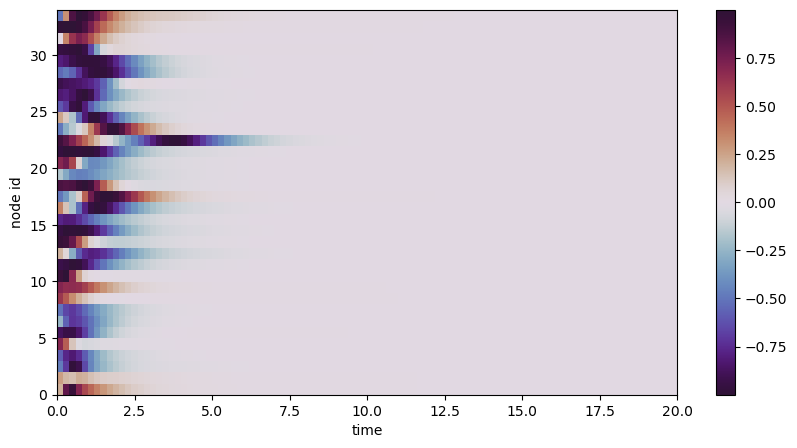

In [226]:
plot_kuramoto(results)


Notice how the above plot reaches a steady state where all oscillators (rows in the heatmap) converge towards 0 degree phase. The oscillators are all now phase-locked and synchronised, all rotating together! 

*Note: You might expect this plot to oscillate, but our natural frequency is set to zero.*

Can we measure this convergence towards sychronisation quantitatively? Yes, we can do this using the order parameter!

![title](images/kuramoto.gif)

Notice how in the above gif, that as the oscillators (orange) begin to synchronise, the blue dot moves towards the outside of the unit circle. This blue dot is our 'order parameter'. We can compute the order parameter as,

\begin{align}
r = \left | \frac{1}{N}\sum_{j=1}^{N} e^{i \theta_j} \right |
\end{align}

which can also be defined in terms of the graph incidence matrix as,

\begin{align}
r = cos(B \theta)
\end{align}

To get a feeling for this order parameter, there is a nice applet at this link: https://mathinsight.org/applet/kuramoto_order_parameters which explains the idea further.


In [227]:
# defining an order parameter
def compute_order_parameter(result, B):
    """Compute the node Kuramoto order parameter."""    
    return np.cos(B.dot(result))


(-0.1, 1.1)

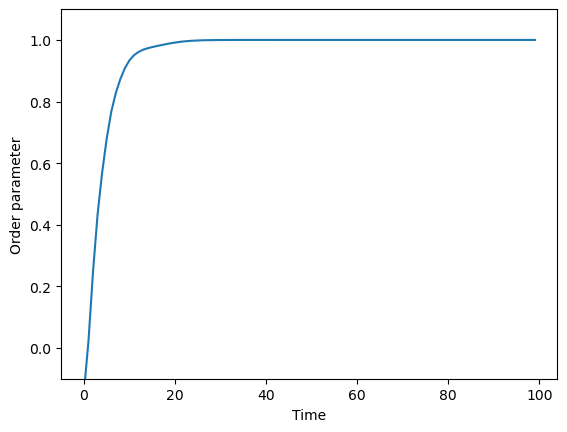

In [228]:
#  computing order and plotting the mean over time
order = compute_order_parameter(results['y'],B)
plt.figure();plt.plot(order.mean(axis=0)); 
plt.ylabel('Order parameter');plt.xlabel('Time');plt.ylim([-0.1,1.1])

Now we can start looking at more interesting scenarios!



Lets first reduce the connection strength between oscillators...

(-0.1, 1.1)

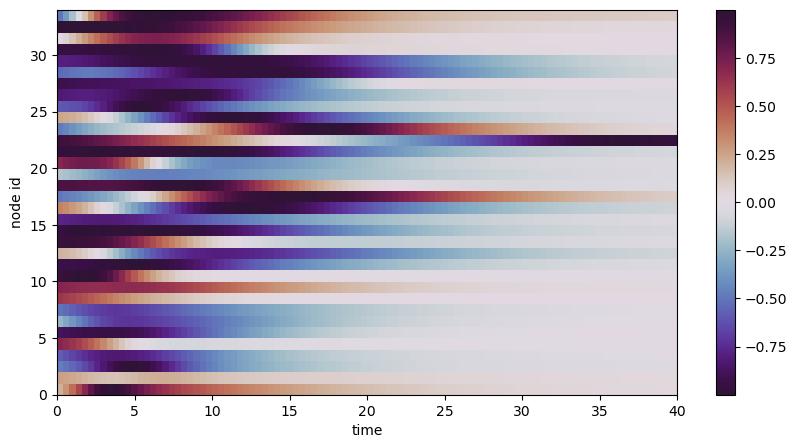

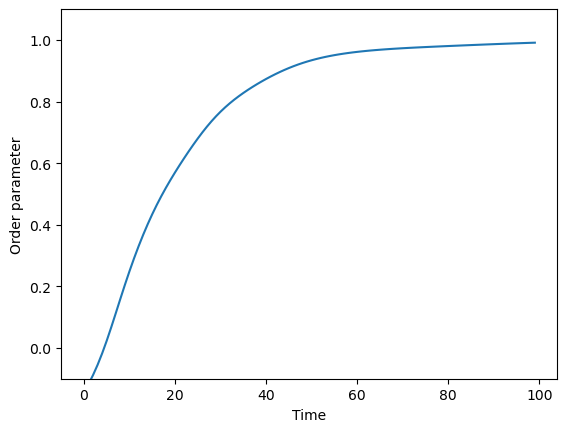

In [229]:
# solving system with reduced sigma
t_max = 40
n_t = 100
results = integrate_kuramoto(
    B, initial_phase, t_max, n_t, natural_freqs=0, alpha_1=0, sigma=0.1
)
plot_kuramoto(results)

order = compute_order_parameter(results['y'],B)
plt.figure();plt.plot(order.mean(axis=0)); 
plt.ylabel('Order parameter');plt.xlabel('Time');plt.ylim([-0.1,1.1])

Notice how it is taking longer to converge now that we reduced the interaction strength between oscillators.

Lets now change the natural frequencies and see what happens..

(-0.1, 1.1)

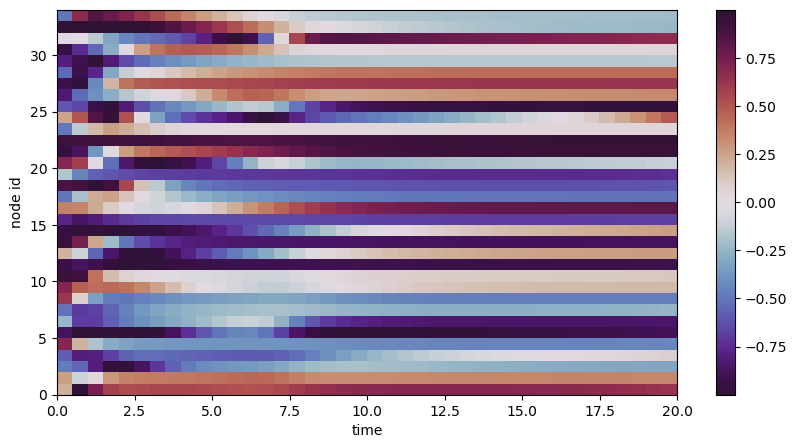

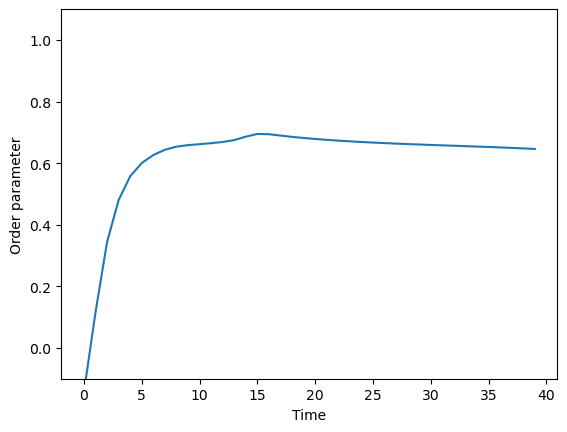

In [230]:
# random frequencies with sigma=0.5
natural_freqs = np.random.random(B.shape[1])
t_max = 20
n_t = 40

results = integrate_kuramoto(
    B, initial_phase, t_max, n_t, natural_freqs=natural_freqs, alpha_1=0, sigma=0.5
)
plot_kuramoto(results)

order = compute_order_parameter(results['y'],B)
plt.figure();plt.plot(order.mean(axis=0)); 
plt.ylabel('Order parameter');plt.xlabel('Time');plt.ylim([-0.1,1.1])

They seem to synchronise but they are out of phase!

(-0.1, 1.1)

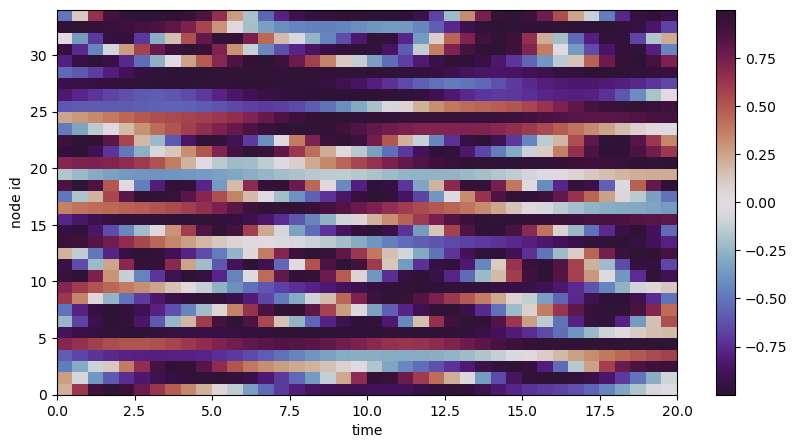

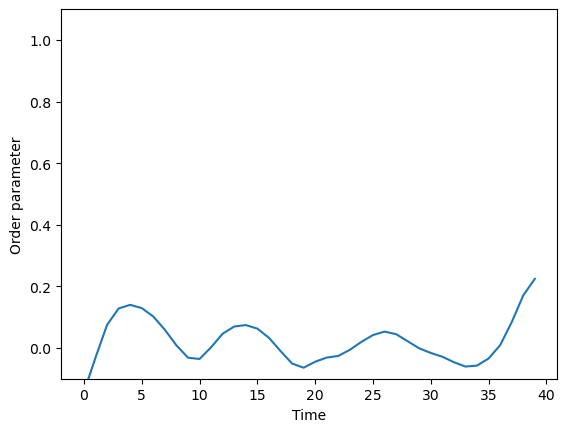

In [234]:
# random frequencies with sigma=0.1
natural_freqs = np.random.random(B.shape[1])
t_max = 20
n_t = 40

results = integrate_kuramoto(
    B, initial_phase, t_max, n_t, natural_freqs=natural_freqs, alpha_1=0, sigma=0.1
)
plot_kuramoto(results)

order = compute_order_parameter(results['y'],B)
plt.figure();plt.plot(order.mean(axis=0)); 

plt.ylabel('Order parameter');plt.xlabel('Time');plt.ylim([-0.1,1.1])

Notice how our oscillators don't seem to be sychronising when sigma is too low. We need to connection strength to be sufficient to create synchronisation!

Now comes the role of the network. We saw that the interaction strength is important, but what about the topology of the network?

Here, we will use a stochastic block model (generative model) to create some modular network structure!


/tmp/ipykernel_47297/3961058471.py:10: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  B = nx.incidence_matrix(g).T


(127, 45)

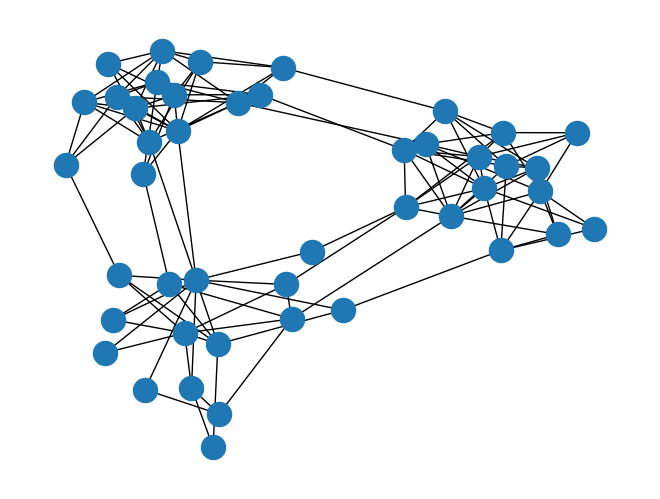

In [235]:
# defining a network with 45 nodes and 3 communities
sizes = [15, 15, 15]

# probabilities of linking nodes between communities
probs = [[0.40, 0.02, 0.02], [0.02, 0.40, 0.02], [0.02, 0.02, 0.40]]

# generate network
g = nx.stochastic_block_model(sizes, probs, seed=0)
nx.draw(g)
B = nx.incidence_matrix(g).T
B.shape

In [236]:
initial_phase = np.random.uniform(low=-np.pi, high=np.pi,size=B.shape[1])
natural_freqs = np.random.random(B.shape[1])
t_max = 100
n_t = 400

results = integrate_kuramoto(
    B, initial_phase, t_max, n_t, natural_freqs=natural_freqs, alpha_1=0, sigma=0.2
)

(-0.1, 1.1)

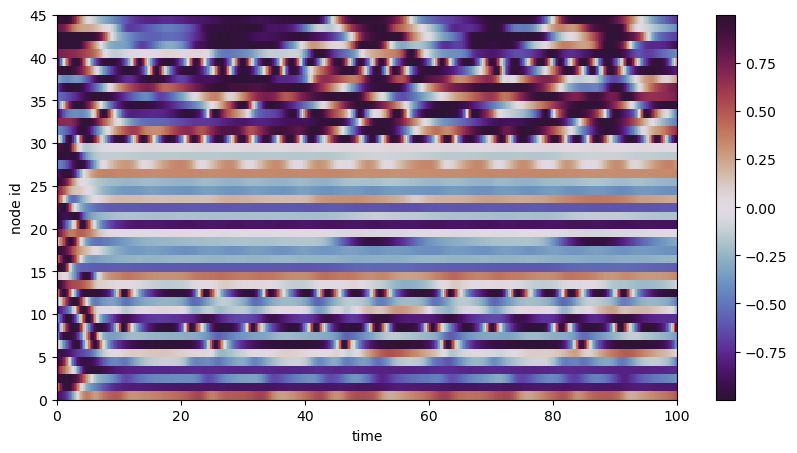

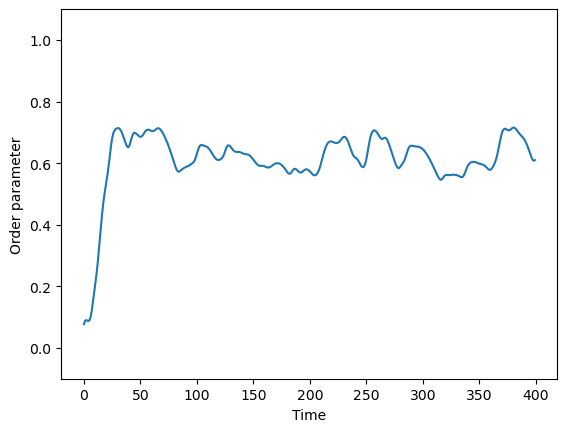

In [237]:
plot_kuramoto(results)
order = compute_order_parameter(results['y'],B)
plt.figure();plt.plot(order.mean(axis=0)); 

plt.ylabel('Order parameter');plt.xlabel('Time');plt.ylim([-0.1,1.1])

It sort of looks like some of the communities are synchronised?

Lets check out the order within each community!

In [238]:
def compute_cluster_order_parameter(result, B, partition):
    """Compute the node Kuramoto order parameter for a cluster of nodes."""    
    
    order = []
    for cluster in partition:
        order_partition = np.cos(B[:,list(cluster)].dot(result[list(cluster),:]))
        order.append(order_partition)
    
    return order

partition = nx.algorithms.community.louvain_communities(g)

# partition
order = compute_cluster_order_parameter(results['y'], B, partition)



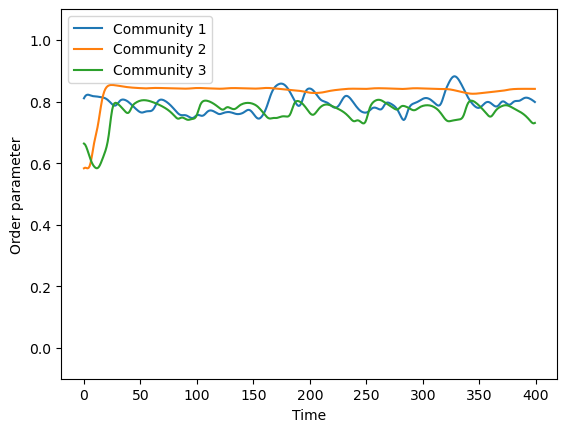

In [240]:
plt.plot(order[0].mean(axis=0),label='Community 1')
plt.plot(order[1].mean(axis=0),label='Community 2')
plt.plot(order[2].mean(axis=0),label='Community 3')
plt.ylabel('Order parameter');plt.xlabel('Time');plt.ylim([-0.1,1.1])
plt.legend()

We start to see better order within the communities, suggesting within cluster synchronisation, but not between cluster!

There are many more things we can change, and some very exciting dynamics to explore. But hopefully this gives you a feeling for synchronisation models and we will move onto other things!

## Epidemic models

Now for another dynamical model! And rather fitting since we are all sitting here with our masks, trying to prevent the spread of COVID-19.
There is a long successful history of mathematical modelling informing policies to mitigate the impact of infectious disease. In fact, we need only look as far Prof. Neil Ferguson's influence over international covid policy through his epidemiological models!

Typically, models divide the population into compartments based on infection status and use simple assumptions about mixing and movements between these compartments. Over time, these models have grown more sophisticated to more accurately incorporate the contact structure of the population and to take advantage of increased computational resources.

Developing a basic model of how diseases progress within an individual and how they spread between individuals is the first important step in modelling. For example, a simplistic view of treatable/curable sexually transmitted infections is that individuals can either be susceptible (S) or infectious (I) and that upon being infected an  individual can get treatment and then return to the susceptible cohort (S) or recover (R) without further suscepbility.

![title](images/gillespie.gif)


A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of $N$ individuals into three "compartments" which may vary as a function of time, $t$:

1. S(t)  are those susceptible but not yet infected with the disease;
2. I(t) is the number of infectious individuals;
3. R(t) are those individuals who have recovered from the disease and now have immunity to it.


The SIR model describes the change in the population (size N) of each of these compartments in terms of two parameters, $\beta$ and $\gamma$.:
1. $\beta$ describes the effective contact rate of the disease:  an infected individual comes into contact with $\beta N$ other individuals per unit time (of which the fraction that are susceptible to contracting the disease is $S/N$).
2. $\gamma$ is the mean recovery rate: that is, $1/\gamma$ is the mean period of time during which an infected individual can pass it on.


The dynamics are then governed by the following differential equations:

\begin{align}
\dot{S}(t) = - \beta I(t) \frac{S(t)}{N} &&
\dot{I}(t) = - \beta I(t) \frac{S(t)}{N} - \gamma I(t) &&
\dot{R}(t) =  \gamma I(t)
\end{align}





Now we could explore another numerical solution to the above systems of analytic equations. However, we don't want to simply repeat what we did with the Kuramoto model! Instead let us look at a stochastic simulation of the epidemic model. Naturally these results should come out similarly.



We are going to start with the SIR model. A very simple model where we assume that individuals are infected for exactly one unit of time and then recover with immunity. We are also ignoring the original edge weights here since our weights our now determined by the probability of infection $\beta$.

Below we have written a function that will perform an SIR simulation on a given network structure, a given infection probability $\beta$ and a maximum number of discrete time steps. 

In [242]:
import random 
from collections import defaultdict

def sir_simulation(G, infection_probability = 0.5, tmax=10, initial_infected=None):

    # initial infected isn't defined then randomly choose a node
    if initial_infected is None:
        initial_infected_nodes=random.sample(G.nodes(), 1)

    I = [len(initial_infected_nodes)] # defining the number of initially infected
    R = [0] # defining the number of initially recovered
    S = [G.order()-I[0]-R[0]] # defining the number of initially susceptible
    t = [0] # defining initial starting time

    # define a dictionary 
    susceptible_nodes = defaultdict(lambda: True)  

    # the seed nodes for our simulation are 'infected' and therefore not 'susceptible'
    for u in initial_infected_nodes:
        susceptible_nodes[u] = False

    # converting our list of initial infected nodes into a set
    infected_nodes = set(initial_infected_nodes)


    # loop the simulation until we (1) run out of infected nodes or (2) run out of time.
    while t[-1]<tmax-1:

        # define an empty set of newly infected nodes for each loop
        newly_infected_nodes = set()

        # loop over all infected nodes
        for u in infected_nodes:

            # loop over neighbours of each infected node
            for v in G.neighbors(u):

                # if a neighbour is susceptible then see if we can infect
                if susceptible_nodes[v]:

                    # generate random number and ask if its smaller than infection probability
                    if random.random()<infection_probability:

                        # add newly infected node
                        newly_infected_nodes.add(v)

                        # if infected, then no longer susceptible
                        susceptible_nodes[v] = False

        # overwrite the infected nodes with the newly infected nodes
        infected_nodes = newly_infected_nodes

        # counting how many recovered, infected, and susceptible at each time point
        R.append(R[-1]+I[-1])
        I.append(len(infected_nodes))
        S.append(S[-1]-I[-1])
        t.append(t[-1]+1)

    return t, S, I, R 
    

In [243]:
# plotting function of the simulated dynamics
def plot_sir(G,t, S, I, R ):
    

    plt.plot(t,R,label='Recovered');
    plt.plot(t,I,label='Infected');
    plt.plot(t,S,label='Susceptible');
    plt.legend()
    
    plt.ylim([0, len(G)])


Lets use the karate club and see what happens!


/tmp/ipykernel_47297/246142116.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes=random.sample(G.nodes(), 1)


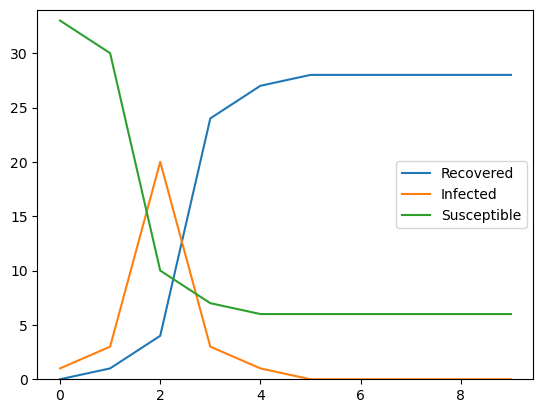

In [244]:
G = nx.karate_club_graph()

t, S, I, R  = sir_simulation(G, infection_probability=0.5)

plot_sir(G, t, S, I, R)

Notice that if you run the above cell multiple times, you will get different results owing to the stochasticity of the simulated system. In light of this, lets repeat the simulation many times and see how many people ended up infected overall with varying infection probabilities!

In [245]:
n_repeats = 100
n_samples = 10
tmax=10

probabilities = np.logspace(-2,0,n_samples)
total_infected = np.zeros([n_repeats,n_samples])

for p, prob in enumerate(probabilities):
    for r in range(n_repeats):

        # run a single simulation
        t, S, I, R  = sir_simulation(G, infection_probability=prob, tmax=tmax)

        # store all the simulations
        total_infected[r,p] = R[-1]

    

/tmp/ipykernel_47297/246142116.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes=random.sample(G.nodes(), 1)


Text(0, 0.5, 'Cumulative infected')

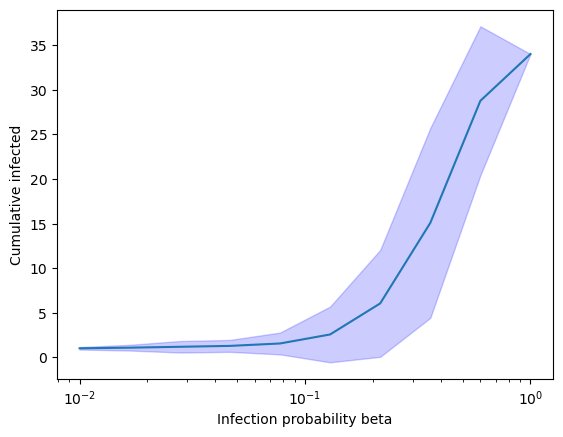

In [246]:
mean_infect = total_infected.mean(axis=0)
std_infect = total_infected.std(axis=0)

plt.plot(probabilities, mean_infect)
plt.fill_between(probabilities, mean_infect - std_infect, mean_infect + std_infect, color='b', alpha=0.2)
plt.xscale('log')
plt.xlabel('Infection probability beta')
plt.ylabel('Cumulative infected')

Notice below how we observe a sort of transition from very few being infected to all being infected as we increase the infection probability, i.e., the relationship between infection probability and total infected is not linear. There seems to be some sort of critical point where the system moves from a non-epidemic state to an epidemic state.


*Note: In-part, the interest that epidemic spreading model have attracted within the statistical physics community stems from the close connection between these models and more standard nonequilibrium problems in statistical
physics. In particular, the epidemic threshold concept is analogous to the concept of phase transition in non-equilibrium systems. A phase transition is defined as an abrupt change in the state (phase) of a system, characterized by qualitatively different properties.*




Could we identify this critical point in our systems dynamics using the original network structure? 

The point at which a linearised system becomes unstable is often used to predict the epidemic threshold. We can identify this point by taking the eigendecomposition of our (unweighted) adjacency matrix and find the maximum eigenvalue:


\begin{align}
\beta_\mathrm{crit}  = 1 / \lambda
\end{align}


Beta critical =  0.14868345865316226


/tmp/ipykernel_47297/2704236640.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G,weight=None) #ignore weights


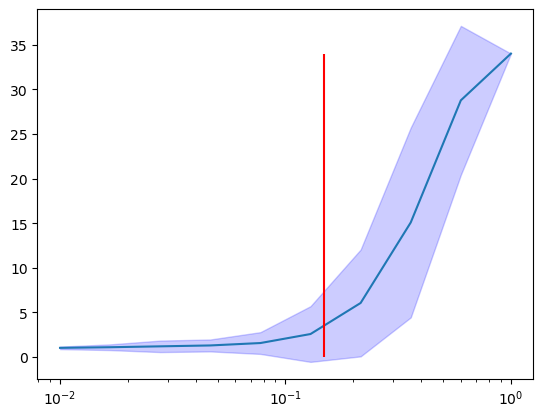

In [247]:
A = nx.adjacency_matrix(G,weight=None) #ignore weights
w,v = np.linalg.eigh(A.toarray())
beta_crit = 1/np.max(w)
print('Beta critical = ', beta_crit)

mean_infect = total_infected.mean(axis=0)
std_infect = total_infected.std(axis=0)

plt.plot(probabilities, mean_infect)
plt.fill_between(probabilities, mean_infect - std_infect, mean_infect + std_infect, color='b', alpha=0.2)
plt.xscale('log');
plt.vlines(beta_crit,ymin=0,ymax=len(G), color='r')

The prediction of $\beta_\mathrm{crit}$ isn't particularly good, maybe this is due to our small network size. Lets try something a bit bigger...

In [248]:
graph = nx.gnm_random_graph(200,1000)

n_repeats = 100
n_samples = 10

probabilities = np.logspace(-2,0,n_samples)
total_infected = np.zeros([n_repeats,n_samples])


for p, prob in enumerate(probabilities):
    for r in range(n_repeats):

        # run a single simulation
        t, S, I, R  = sir_simulation(graph, infection_probability=prob, tmax=tmax)

        # store all the simulations
        total_infected[r,p] = R[-1]


/tmp/ipykernel_47297/246142116.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected_nodes=random.sample(G.nodes(), 1)


Beta critical =  0.09098891558314433


/tmp/ipykernel_47297/2171094529.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(graph, dtype=np.float64, weight=None) #ignore weights


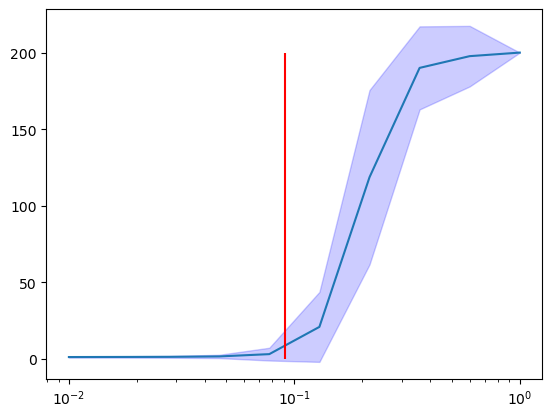

In [249]:
A = nx.adjacency_matrix(graph, dtype=np.float64, weight=None) #ignore weights
w,v = np.linalg.eigh(A.toarray())
beta_crit = 1/np.max(w)
print('Beta critical = ', beta_crit)

mean_infect = total_infected.mean(axis=0)
std_infect = total_infected.std(axis=0)

plt.plot(probabilities, mean_infect)
plt.fill_between(probabilities, mean_infect - std_infect, mean_infect + std_infect, color='b', alpha=0.2)
plt.xscale('log')
plt.vlines(beta_crit,ymin=0,ymax=len(graph), color='r')

Clearly the estimation isn't perfect, but it gives a general indication of when the infection dynamics transition to an epidemic. This is likely because the maximum eigenvalue doesn't capture enough information about the local network structure.

#### Summary of epidemics

So we have seen how (very simple) epidemics can be simulated on networks. **But is this realistic?**
How would you change things? What other aspects would you want to see in a more realistic model? Some strands of network research explore exactly this.